# Anime Recommendation System

## Problem Definition

<p>
Anime similarity based on user rating pattern refers to the measure of how similar anime are based on ratings given by users. This approach takes users' preferences into account and seeks to find anime that has been rated similarly by users.

There are several techniques that can be used to calculate the similarity between anime based on user ratings. In this project we will use the approach of:

Cosine Similarity: This measure calculates the similarity between two user evaluation vectors, considering the angle between them. The smaller the angle, the greater the similarity between the animes.


It is important to emphasize that the choice of similarity measure depends on the context and characteristics of the available data. Furthermore, the quality of user ratings and the amount of data available also influence the similarity calculation results.

Based on the calculated similarity measures, it is possible to create a recommendation system that suggests similar anime based on user ratings. This allows users to discover anime with rating patterns similar to their own, increasing the likelihood that they will appreciate the suggestions offered by the system.
</p>

Goals:

1. Develop an anime similarity system according to the users' rating standard



## Data source

<p>
Myanimelist.net provided a lot of rating data for various anime. This dataset contains information about the user preference data of 73,516 users in 12,294 anime.
</p>

<ul>
<li> <a href="https://www.myanimelist.net">MyAnimeList</a></li>
<li> <a href="https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database">Dataset</a></li>

## Installing and Loading Packages

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# Graphic formatting
matplotlib.use('nbagg')
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style('whitegrid')

## Loading the Data

In [2]:
print("Creating pandas dataframe from data file...")
df_animes = pd.read_csv('dados/rating.csv', sep = ',')
print('Concluded.')

Creating pandas dataframe from data file...
Concluded.


In [3]:
# Shape
df_animes.shape

(7813737, 3)

In [4]:
df_animes = df_animes[df_animes['rating'] != -1]

In [5]:
# Shape
df_animes.shape

(6337241, 3)

In [6]:
# Visualizing the data
df_animes.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


## Exploratory Data Analysis

In [7]:
# Data summary
print("Data summary")
print("-"*50)
print("Total Number of Anime:", len(np.unique(df_animes.anime_id)))
print("Total Number of Users:", len(np.unique(df_animes.user_id)))
print("Total Number of Reviews:", df_animes.shape[0])

Data summary
--------------------------------------------------
Total Number of Anime: 9927
Total Number of Users: 69600
Total Number of Reviews: 6337241


In [8]:
# Let's save these two values ​​to use later
total_users = len(np.unique(df_animes.user_id))
total_animes = len(np.unique(df_animes.anime_id))

In [9]:
# Checking the average of the ratings
df_animes.describe()['rating']

count    6.337241e+06
mean     7.808497e+00
std      1.572496e+00
min      1.000000e+00
25%      7.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      1.000000e+01
Name: rating, dtype: float64

In [10]:
# Checking for missing values
sum(df_animes.isnull().any())

0

In [11]:
# Checking if we have duplicate values ​​(in this case we don't consider the date)
sum(df_animes.duplicated(['anime_id', 'user_id', 'rating']))

1

In [12]:
df_animes.drop_duplicates(['anime_id', 'user_id', 'rating'], inplace=True)

In [13]:
# Checking if we have duplicate values ​​(in this case we don't consider the date)
sum(df_animes.duplicated(['anime_id', 'user_id', 'rating']))

0

The function below will adjust the measurements in thousands, millions and billions to make the graphs easier to read.

In [14]:
# Function to adjust the measurement units
def ajusta_unidades(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [15]:
# Supress warnings
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

__Let's check the distribution of ratings.__

<IPython.core.display.Javascript object>


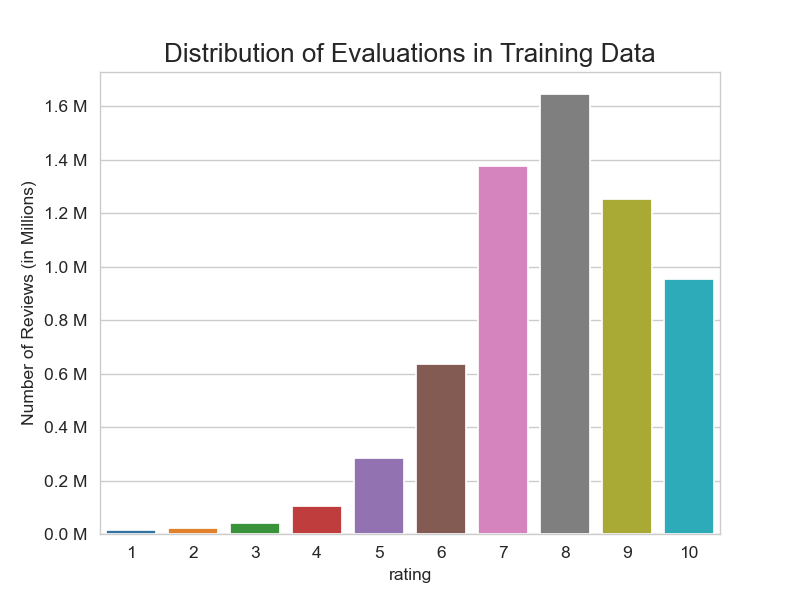

In [16]:
# Plot
fig, ax = plt.subplots()
plt.title('Distribution of Evaluations in Training Data', fontsize = 15)
sns.countplot(df_animes.rating)
ax.set_yticklabels([ajusta_unidades(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('Number of Reviews (in Millions)')
plt.show()

__Let's check the users who made the most reviews of Animes.__

In [17]:
# Number of ratings per user
num_aval_por_user = df_animes.groupby(by = 'user_id')['rating'].count().sort_values(ascending = False)
num_aval_por_user.head()

user_id
42635    3747
53698    2905
57620    2689
59643    2632
51693    2621
Name: rating, dtype: int64

In [18]:
# Statistical summary
num_aval_por_user.describe()

count    69600.000000
mean        91.052299
std        135.764253
min          1.000000
25%         13.000000
50%         45.000000
75%        114.000000
max       3747.000000
Name: rating, dtype: float64

__Let's create a plot of the probability density function function and the cumulative distribution function.__

The probability density function (pdf) and cumulative distribution function (cdf) are two of the most important statistical functions in reliability and are closely related. When these functions are known, almost any other reliability measure of interest can be derived or obtained.

<IPython.core.display.Javascript object>


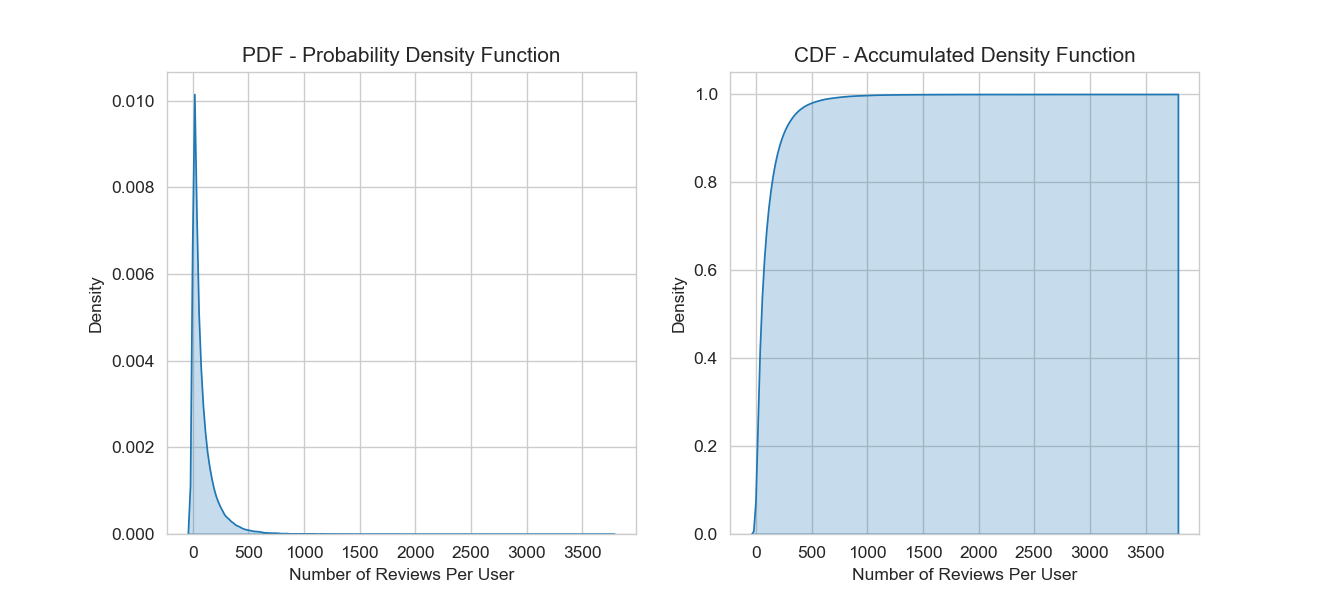

In [19]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
ax1 = plt.subplot(121)
sns.kdeplot(num_aval_por_user, shade = True, ax = ax1)
plt.xlabel('Number of Reviews Per User')
plt.title("PDF - Probability Density Function")
ax2 = plt.subplot(122)
sns.kdeplot(num_aval_por_user, shade = True, cumulative = True, ax = ax2)
plt.xlabel('Number of Reviews Per User')
plt.title('CDF - Accumulated Density Function')
plt.show()

Note that the vast majority of users have less than 500 reviews.

## Sparse Matrix Creation

### Sparse Matrix Creation

In [20]:
if os.path.isfile('dados/matriz_esparsa.npz'):
    matriz_esparsa = sparse.load_npz('dados/matriz_esparsa.npz')
    print("Matriz Carregada.")
else: 
    matriz_esparsa = sparse.csr_matrix((df_animes.rating.values, (df_animes.user_id.values, 
                                                                                 df_animes.anime_id.values)),)
    print('Matrix Created. The shape is: (user_id, anime_id): ', matriz_esparsa.shape)
    sparse.save_npz("dados/matriz_esparsa.npz", matriz_esparsa)
    print('Matriz Saved to Disk.')

Matrix Created. The shape is: (user_id, anime_id):  (73517, 34476)
Matriz Saved to Disk.


In [21]:
# Calculate the matrix sparsity
linhas, colunas = matriz_esparsa.shape
elementos_nao_zero = matriz_esparsa.count_nonzero()
print("Sparsity of the Matrix: {} % ".format(  (1 - (elementos_nao_zero / (linhas * colunas))) * 100) )

Sparsity of the Matrix: 99.74996828774361 % 


__We will calculate the global average of all anime ratings, average rating per user and average rating per anime.__

In [22]:
# Below we calculate the global average of all user ratings.
medias = dict()
medias_global = matriz_esparsa.sum() / matriz_esparsa.count_nonzero()
medias['global'] = medias_global
medias

{'global': 7.808504309608892}

__Let's build a function to calculate the average rating.__

In [23]:
def calcula_media_avaliacoes(sparse_matrix, of_users):
    

    ax = 1 if of_users else 0

    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    
    is_rated = sparse_matrix!=0

    no_of_ratings = is_rated.sum(axis=ax).A1
    
    u, m = sparse_matrix.shape
    
    media_aval = {i:sum_of_ratings[i]/no_of_ratings[i] for i in range(u if of_users else m) if no_of_ratings[i]!=0}

    return media_aval

__Below we calculate the average of ratings per user.__

In [24]:
# Average user ratings
medias['user'] = calcula_media_avaliacoes(matriz_esparsa, of_users = True)

In [25]:
# Print
print('Average User Rating 149:', medias['user'][149])

Average User Rating 149: 8.909090909090908


__Below we calculate the average ratings per anime.__

In [26]:
# Average ratings per anime
medias['anime'] =  calcula_media_avaliacoes(matriz_esparsa, of_users = False)

In [27]:
# Print
print('Average Anime Rating 32 :', medias['anime'][32])

Average Anime Rating 32 : 8.405749293119698


__PDFs and media CDs. User ratings and anime (training data).__

<IPython.core.display.Javascript object>


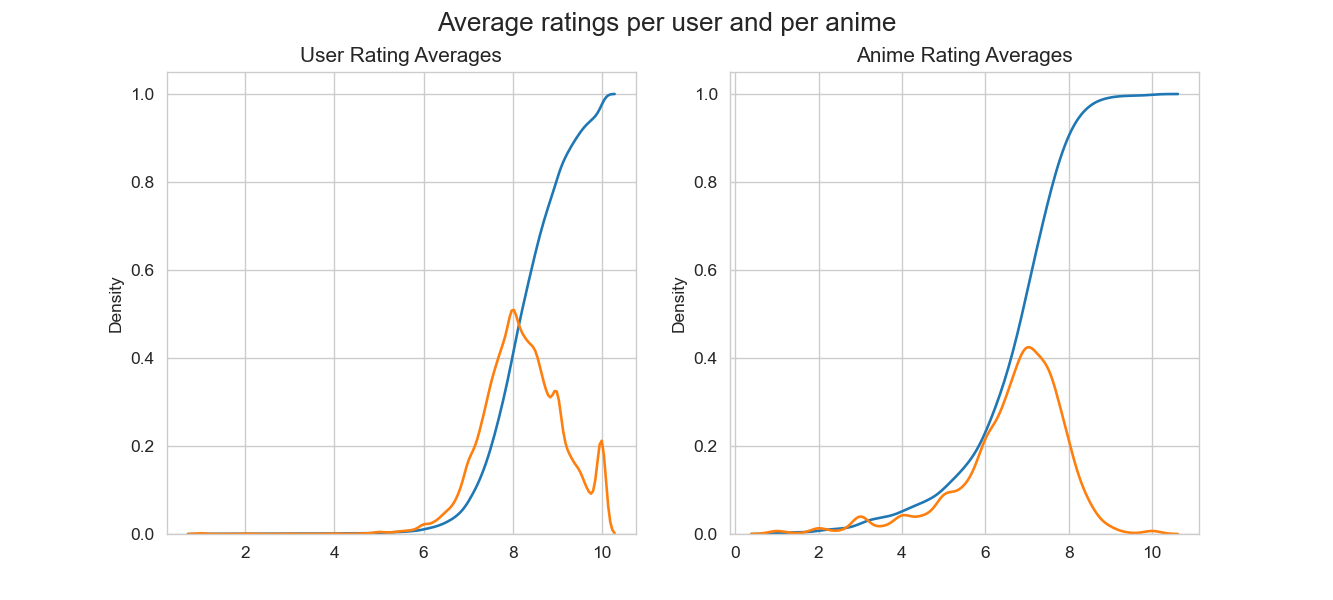

In [29]:
# Plot
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = plt.figaspect(.45))
fig.suptitle('Average ratings per user and per anime', fontsize = 15)

ax1.set_title('User Rating Averages')

medias_usuarios = [rat for rat in medias['user'].values()]
sns.distplot(medias_usuarios, ax = ax1, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_usuarios, ax = ax1, hist = False, label = 'PDF')

ax2.set_title('Anime Rating Averages')

medias_anime = [rat for rat in medias['anime'].values()]
sns.distplot(medias_anime, ax = ax2, hist = False, kde_kws = dict(cumulative = True), label = 'CDF')
sns.distplot(medias_anime, ax = ax2, hist = False, label = 'PDF')

plt.show()

## Calculating the User Similarity Matrix

In [30]:
def calcula_similaridade_usuario(sparse_matrix, 
                                 compute_for_few = False, 
                                 top = 100, 
                                 verbose = False, 
                                 verb_for_n_rows = 20,
                                 draw_time_taken = True):
    
    no_of_users, _ = sparse_matrix.shape
    row_ind, col_ind = sparse_matrix.nonzero()
    row_ind = sorted(set(row_ind)) 
    time_taken = list()
    rows, cols, data = list(), list(), list()
    if verbose: print("Calculando top", top, "similarities for each user...")
    start = datetime.now()
    temp = 0
    
    for row in row_ind[:top] if compute_for_few else row_ind:
        temp = temp + 1
        prev = datetime.now()
        
        sim = cosine_similarity(sparse_matrix.getrow(row), sparse_matrix).ravel()
        top_sim_ind = sim.argsort()[-top:]
        top_sim_val = sim[top_sim_ind]
        rows.extend([row]*top)
        cols.extend(top_sim_ind)
        data.extend(top_sim_val)
        time_taken.append(datetime.now().timestamp() - prev.timestamp())
        
        if verbose:
            if temp%verb_for_n_rows == 0:
                print("Completed calculation for {} users [ total time: {}  ]".format(temp, datetime.now()-start))
            
    if verbose: print('Creation of sparse matrix from computed similarities...')    
        
    if draw_time_taken:
        plt.plot(time_taken, label = 'Calculation time for each user')
        plt.plot(np.cumsum(time_taken), label = 'Total time')
        plt.legend(loc = 'best')
        plt.xlabel('User')
        plt.ylabel('Time (seg)')
        plt.show()
        
    return sparse.csr_matrix((data, (rows, cols)), shape = (no_of_users, no_of_users)), time_taken      

Calculando top 100 similarities for each user...
Completed calculation for 20 users [ total time: 0:00:04.086077  ]
Completed calculation for 40 users [ total time: 0:00:08.150235  ]
Completed calculation for 60 users [ total time: 0:00:12.211371  ]
Completed calculation for 80 users [ total time: 0:00:16.220855  ]
Completed calculation for 100 users [ total time: 0:00:20.238036  ]
Creation of sparse matrix from computed similarities...


<IPython.core.display.Javascript object>


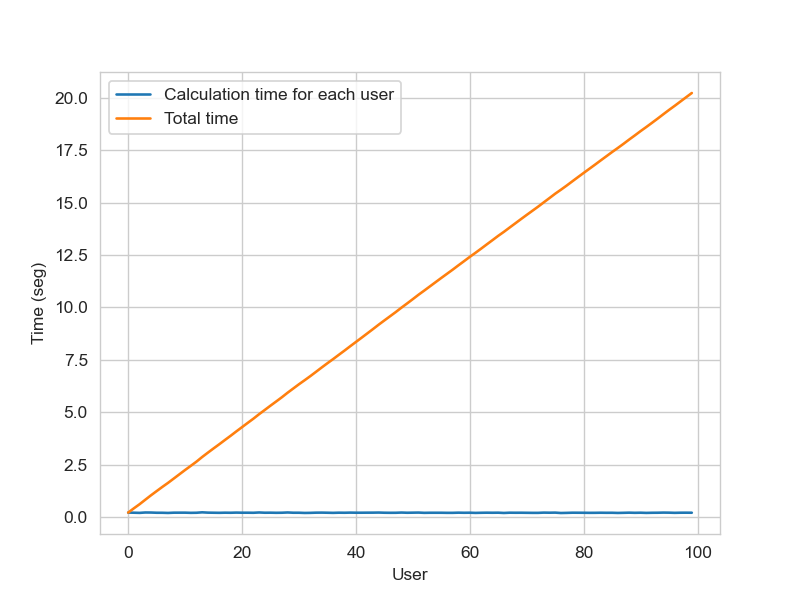

Total Processing Time: 0:00:20.696588


In [31]:
start = datetime.now()

matriz_esparsa_user, _ = calcula_similaridade_usuario(matriz_esparsa, 
                                                      compute_for_few = True, 
                                                      top = 100, 
                                                      verbose = True)

print("Total Processing Time:", datetime.now() - start)

In [32]:
matriz_esparsa_user.shape

(73517, 73517)

In [33]:
# Tipo
type(matriz_esparsa_user)

scipy.sparse._csr.csr_matrix

In [34]:
if not os.path.isfile('dados/matriz_esparsa_user.npz'):
    matriz_esparsa_user = sparse.csr_matrix(matriz_esparsa_user)
    sparse.save_npz('dados/matriz_esparsa_user', matriz_esparsa_user)
else:
    matriz_esparsa_user = sparse.load_npz('dados/matriz_esparsa_user.npz')

In [35]:
#shape
matriz_esparsa_user.shape

(73517, 73517)

__Now we recalculate the similarity of users using the truncated matrix.__

Calculando top 50 similarities for each user...
Completed calculation for 20 users [ total time: 0:00:00.050896  ]
Completed calculation for 40 users [ total time: 0:00:00.092780  ]
Creation of sparse matrix from computed similarities...


<IPython.core.display.Javascript object>


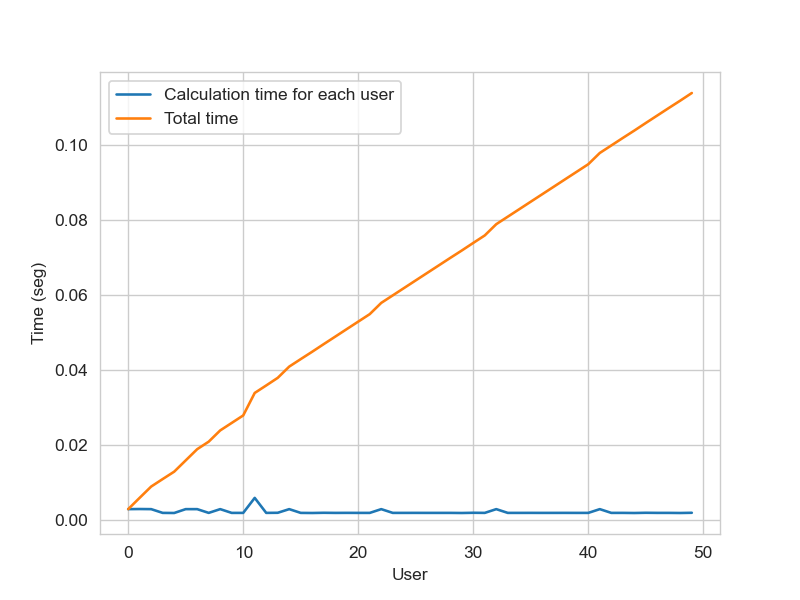

Processing time: 0:00:00.135637


In [36]:
start = datetime.now()

trunc_sim_matrix, _ = calcula_similaridade_usuario(matriz_esparsa_user, 
                                                   compute_for_few = True, 
                                                   top = 50, 
                                                   verbose = True) 

print("Processing time:", datetime.now() - start)

## Calculating Anime Similarity Matrix

In [37]:
start = datetime.now()

if not os.path.isfile('dados/matriz_esparsa_anime.npz'):
    matriz_esparsa_anime = cosine_similarity(X = matriz_esparsa.T, dense_output = False)
    print("Matrix Created.")
    sparse.save_npz("dados/matriz_esparsa_anime.npz", matriz_esparsa_anime)
    print("Matriz Saved to Disk.")
else:
    matriz_esparsa_anime = sparse.load_npz("dados/matriz_esparsa_anime.npz")
    print("Loaded Matrix.")

print("Processing time:", datetime.now() - start)

Matrix Created.
Matriz Saved to Disk.
Processing time: 0:00:47.690681


In [38]:
# Shape
matriz_esparsa_anime.shape

(34476, 34476)

In [39]:
df_similarities = pd.DataFrame(matriz_esparsa_anime.toarray())

In [40]:
df_similarities.head(10)

,0,1,2,3,4,5,6,7,8,9,...,34466,34467,34468,34469,34470,34471,34472,34473,34474,34475
0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,1.000000,0.0,0.0,0.0,0.607757,0.534823,0.256910,0.071918,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011319
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.607757,0.0,0.0,0.0,1.000000,0.413588,0.250765,0.059980,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005825
6,0.0,0.534823,0.0,0.0,0.0,0.413588,1.000000,0.273966,0.096445,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007739
7,0.0,0.256910,0.0,0.0,0.0,0.250765,0.273966,1.000000,0.082593,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.071918,0.0,0.0,0.0,0.059980,0.096445,0.082593,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [41]:
# Extract anime ids
animes_ids = np.unique(matriz_esparsa_anime.nonzero()[1])

In [42]:
# Calculate similarity of animes according to users rating pattern

start = datetime.now()

animes_similares = dict()

for animes in animes_ids:
    animes_sim = matriz_esparsa_anime[animes].toarray().ravel().argsort()[::-1][1:]
    animes_similares[animes] = animes_sim[:100]
    
print("Processing time:", datetime.now() - start)

Processing time: 0:00:11.142196


In [43]:
# Anime similar to Anime by id 5
animes_similares[5]

array([   1,   43,   47,    6,  205,  227,   30,  467,  164,   32,  468,
        889,  801, 1519,  199, 1943,  572, 2251,  121, 2001,  430, 2759,
        431,  617,  849, 4106,  270, 2236,  543,  405,   44, 1566,   71,
        437,   33,  400,  317,  790,  339, 1210, 3784,  570,   72,  323,
        513,   31,  578,  523, 2025, 5681,  457,   97,  759, 1575,  245,
       4037, 2418,  512, 1303,   73,   66, 6675,  565,   54, 3901,  202,
       1689,  208,  267, 1535,  226,  237,  268, 1292, 5630,  522, 2904,
        416,  134,   45,  182, 1033,  732, 1818, 2593,  240,  387, 5114,
        256,    7, 4901, 1361,  393,  433, 3782, 2605,   57,  379, 2966,
        401], dtype=int64)

__Now let's find the most similar animes using the similarity matrix.__

In [44]:
# Let's load the anime titles from the csv file provided by Netflix
titulos_animes = pd.read_csv("dados/anime.csv", 
                             sep = ',', 
                             header = 0,
                             names = ['anime_id', 'name', 'genre','type','episodes','rating','members'], 
                             verbose = True,
                             index_col = 'anime_id', 
                             encoding = "ISO-8859-1")

Tokenization took: 6.98 ms
Type conversion took: 7.69 ms
Parser memory cleanup took: 0.00 ms


In [45]:
# Visualize the data
titulos_animes.head()

,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,GintamaÂ°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


__Let's see what animes are similar to the ID 5 anime.__

In [46]:
# anime id
id_anime = 5

In [47]:
# Print
print("Anime:", titulos_animes.loc[id_anime].values[0])
print("Total User Ratings = {}.".format(matriz_esparsa[:,id_anime].getnnz()))
print("We found {} Animes that are similar to this one and let's print the most similar ones.".format(matriz_esparsa_anime[:,id_anime].getnnz()))

Anime: Cowboy Bebop: Tengoku no Tobira
Total User Ratings = 5790.
We found 9336 Animes that are similar to this one and let's print the most similar ones.


In [48]:
# Finding all similarities
similarities = matriz_esparsa_anime[id_anime].toarray().ravel()
similar_indices = similarities.argsort()[::-1][1:]
similarities[similar_indices]
sim_indices = similarities.argsort()[::-1][1:] 

<IPython.core.display.Javascript object>


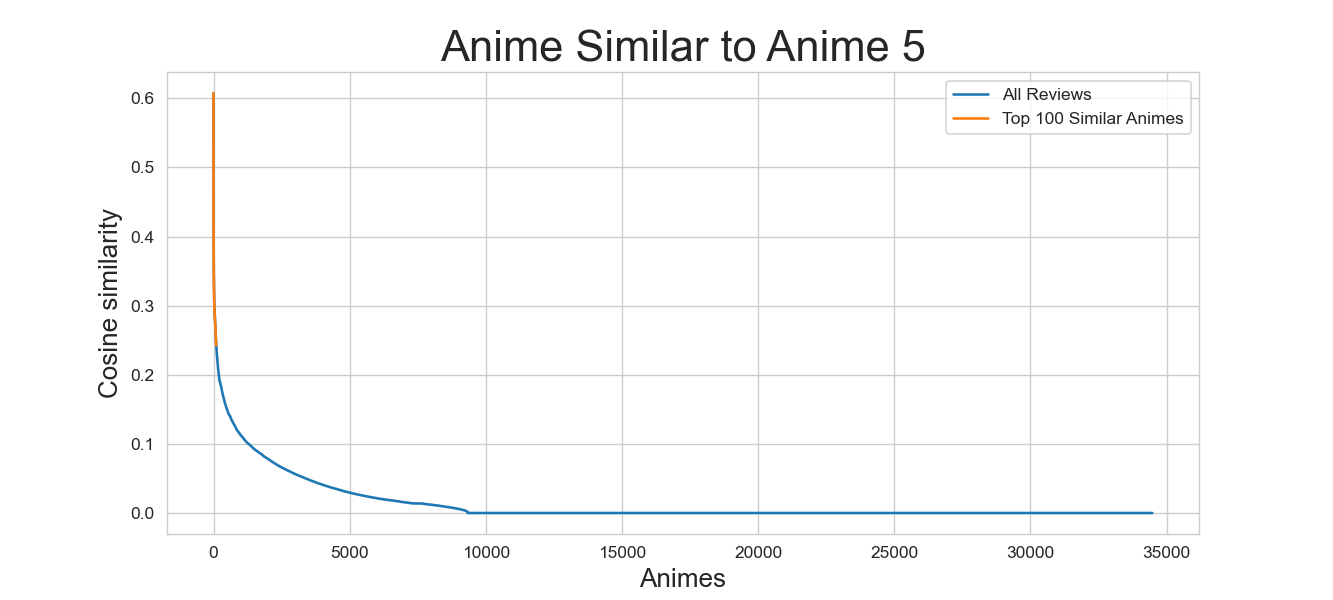

In [49]:
# Plot
fig = plt.figure(figsize = plt.figaspect(.45))
plt.plot(similarities[sim_indices], label = 'All Reviews')
plt.plot(similarities[sim_indices[:100]], label = 'Top 100 Similar Animes')
plt.title("Anime Similar to Anime {}".format(id_anime), fontsize = 25)
plt.xlabel("Animes", fontsize = 15)
plt.ylabel("Cosine similarity", fontsize = 15)
plt.legend()
plt.show()

In [50]:
# Here are the top 10 anime most similar to anime 5
titulos_animes.loc[sim_indices[:10]]

,name,genre,type,episodes,rating,members
anime_id,,,,,,
1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
43,Ghost in the Shell,"Action, Mecha, Police, Psychological, Sci-Fi, ...",Movie,1,8.34,223036
47,Akira,"Action, Adventure, Horror, Military, Sci-Fi, S...",Movie,1,8.15,215897
6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069
205,Samurai Champloo,"Action, Adventure, Comedy, Historical, Samurai...",TV,26,8.50,390076
227,FLCL,"Action, Comedy, Dementia, Mecha, Parody, Sci-Fi",OVA,6,8.06,305165
30,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,26,8.32,461946
467,Ghost in the Shell: Stand Alone Complex,"Action, Mecha, Military, Police, Sci-Fi, Seinen",TV,26,8.47,194491
164,Mononoke Hime,"Action, Adventure, Fantasy",Movie,1,8.81,339556


We could already complete the project here, as we already have a recommendation system.

# Fim